# Staring Array Modelling - Visual low light

This notebook forms part of a series on [computational optical radiometry](https://github.com/NelisW/ComputationalRadiometry#computational-optical-radiometry-with-pyradi).  The notebooks can be downloaded from [Github](https://github.com/NelisW/ComputationalRadiometry#computational-optical-radiometry-with-pyradi). These notebooks are constantly revised and updated, please revisit from time to time.  


[<img src="https://zenodo.org/badge/doi/10.5281/zenodo.9910.png"   align="left"/>](http://dx.doi.org/10.5281/zenodo.9910)


The date of this document and module versions used in this document are given at the end of the file.  
Feedback is appreciated: neliswillers at gmail dot com.

## Overview

The pyradi [`rystare`](http://nelisw.github.io/pyradi-docs/_build/html/rystare.html) module models the signal and noise in CCD and CMOS staring array sensors.  The code is originally based on the Matlab code described in *'High-level numerical simulations of noise in solid-state photosensors: review and tutorial'* by Mikhail Konnik and James Welsh, arXiv:1412.4031v1 [astro-ph.IM], available [here](http://arxiv.org/pdf/1412.4031.pdf)

Good references for this work include James R Janesick's books ['Photon Transfer'](http://spie.org/Publications/Book/725073) and ['Scientific Charge-Coupled Devices'](http://spie.org/Publications/Book/374903)



In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import re
import os.path
from scipy.optimize import curve_fit
import datetime

from matplotlib import cm as mcm
import matplotlib.mlab as mlab
import scipy.constants as const
import collections

%matplotlib inline

# %reload_ext autoreload
# %autoreload 2

# import xlsxwriter

import pyradi.ryplot as ryplot
import pyradi.ryfiles as ryfiles
import pyradi.rystare as rystare
import pyradi.ryutils as ryutils
import pyradi.rypflux as rypflux
import pyradi.ryplanck as ryplanck

from IPython.display import HTML
from IPython.display import Image
from IPython.display import display
from IPython.display import FileLink, FileLinks

#make pngs at stated dpi
import matplotlib as mpl
plotdpi = 72
mpl.rc("savefig", dpi=plotdpi)
mpl.rc('figure', figsize=(10,8))
# %config InlineBackend.figure_format = 'svg'

pd.set_option('display.max_columns', 80)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 150)

# Imager radiometry

## Visual Sensor model data

The following code sets up the sensor model data for a visual sensor.

Files remaining open, not closed after use, poses a problem in the notebook context where cells may be executed indivdually.  To limit the occurence of open files we open and close the file in each cell.

Two visual-band image files are available: (1) a 300 mlux maximum value [a little brighter than full moon] and (2) a 25 lux maximum value [dusk, before twilight]. Each image comprise a staircase from some non-zero low value to the maximum value in 40 steps.  The 25 lux scenario uses an integration time of 10 ms, to achieve full well fill.  The low light case uses a 35 ms integration time, to get maximum signal, but does not achieve full well fill.

In [7]:
#set up the parameters for this run and open the HDF5 file
outfilename = 'Output'
prefix = 'PA'
githubprefix = 'https://github.com/NelisW/pyradi/raw/master/pyradi/data/'
# set this True to use the low light imput image (300 mlux)
if True:
    integrationtime = 0.035
    imagedatafilename = 'image-Stairslin-LowLight-40-100-520.hdf5'
else:    
    integrationtime = 0.0105
    magedatafilename = 'image-Stairslin-40-100-520.hdf5'
pathtoimage = ryfiles.downloadFileUrl('{}{}'.format(githubprefix,imagedatafilename),  
                    saveFilename=imagedatafilename)

In [8]:
#open the file to create data structure and store the results, remove if exists
hdffilename = '{}{}.hdf5'.format(prefix, outfilename)
if os.path.isfile(hdffilename):
    os.remove(hdffilename)

print(hdffilename)
print(pathtoimage)
    

strh5 = ryfiles.open_HDF(hdffilename)

#sensor parameters
strh5['rystare/sensortype'] = 'CCD' # CMOS/CCD must be in capitals

# Light Noise parameters
strh5['rystare/photonshotnoise/activate'] = True #photon shot noise.

#detector parameters
strh5['rystare/photondetector/operatingtemperature'] = 300. # operating temperature, [K]
strh5['rystare/photondetector/geometry/fillfactor'] = 0.95 # Pixel Fill Factor for full-frame CCD photo sensors.
strh5['rystare/photondetector/integrationtime'] = integrationtime # Exposure/Integration time, [sec].
strh5['rystare/photondetector/externalquantumeff'] = 0.8  # external quantum efficiency, fraction not reflected.
strh5['rystare/photondetector/quantumyield'] = 1. # number of electrons absorbed per one photon into material bulk

# light photo response non-uniformity noise (PRNU), or also called light Fixed Pattern Noise (light FPN)
strh5['rystare/photondetector/lightPRNU/activate'] = True
strh5['rystare/photondetector/lightPRNU/seed'] = 362436069
strh5['rystare/photondetector/lightPRNU/model'] = 'Janesick-Gaussian' 
strh5['rystare/photondetector/lightPRNU/sigma'] = 0.01 # sigma [about 1\% for CCD and up to 5% for CMOS];

# detector material bandgap properties 
strh5['rystare/photondetector/varshni/Egap0'] = 1.166  #bandgap energy for 0 degrees of K. [For Silicon, eV]
strh5['rystare/photondetector/varshni/varA'] = 5.5e-04 #Si material parameter, [eV/K].
strh5['rystare/photondetector/varshni/varB'] = 636. #Si material parameter, [K].

# Dark Current Noise parameters
strh5['rystare/photondetector/darkcurrent/activate'] = True
strh5['rystare/photondetector/darkcurrent/densityAm2'] = 1. * 1e-9 * 1e4 # dark current density [A/m2].  
strh5['rystare/photondetector/darkcurrent/ca'] = 4.31e5 # for density in m2
strh5['rystare/photondetector/darkcurrent/ed'] = 2. 
strh5['rystare/photondetector/darkcurrent/shotnoise/activate'] = True # dark current shot noise
strh5['rystare/photondetector/darkcurrent/shotnoise/seed'] = 6214069 
strh5['rystare/photondetector/darkcurrent/shotnoise/model'] = 'Gaussian' 

#dark current Fixed Pattern uniformity 
strh5['rystare/photondetector/darkcurrent/fixedPatternNoise/activate'] = True
strh5['rystare/photondetector/darkcurrent/fixedPatternNoise/seed'] = 362436128
strh5['rystare/photondetector/darkcurrent/fixedPatternNoise/model'] = 'LogNormal' #suitable for long exposures
strh5['rystare/photondetector/darkcurrent/fixedPatternNoise/sigma'] = 0.4 #lognorm_sigma.

#sense node charge to voltage
strh5['rystare/sensenode/gain'] = 50e-06 # Sense node gain, A_SN [V/e]
strh5['rystare/sensenode/vrefreset'] = 3.1 # Reference voltage to reset the sense node. [V] typically 3-10 V.
strh5['rystare/sensenode/vsnmin'] = 0.5 # Minimum voltage on sense node, max well charge [V] typically < 1 V.

strh5['rystare/sensenode/gainresponse/type'] = 'linear'
strh5['rystare/sensenode/gainresponse/k1'] = 1.090900000e-14 # nonlinear capacitance is given by C =  k1/V
if strh5['rystare/sensenode/gainresponse/type'] in ['nonlinear']:
    strh5['rystare/sensenode/fullwellelectronselection/fullwellelectrons'] = \
        -(strh5['rystare/sensenode/gainresponse/k1'].value/const.e) * \
        np.log(strh5['rystare/sensenode/vsnmin'].value/strh5['rystare/sensenode/vrefreset'].value)
else:
    strh5['rystare/sensenode/fullwellelectronselection/fullwellelectrons'] = 2e4 # full well of the pixel (how many electrons can be stored in one pixel), [e]
strh5['rystare/sensenode/resetnoise/activate'] = True
strh5['rystare/sensenode/resetnoise/seed'] = 2154069 
strh5['rystare/sensenode/resetnoise/model'] = 'Gaussian' 
strh5['rystare/sensenode/resetnoise/factor'] = 0.8 #[0,1]the compensation factor of the Sense Node Reset Noise: 

#source follower
strh5['rystare/sourcefollower/gain'] = 1. # Source follower gain, [V/V], lower means amplify the noise.
strh5['rystare/sourcefollower/dataclockspeed'] = 20e6 #Hz data rate clocking speed.
strh5['rystare/sourcefollower/freqsamplingdelta'] = 10000. #Hz spectral sampling spacing
strh5['rystare/sourcefollower/nonlinearity/activate'] = True
strh5['rystare/sourcefollower/nonlinearity/ratio'] = 1.05 # > 1 for lower signal, < 1 for higher signal
strh5['rystare/sourcefollower/noise/activate'] = True
strh5['rystare/sourcefollower/noise/seed'] = 6724069
strh5['rystare/sourcefollower/noise/flickerCornerHz'] = 1e6 #flicker noise corner frequency $f_c$ in [Hz], where power spectrum of white and flicker noise are equal [Hz].
strh5['rystare/sourcefollower/noise/whitenoisedensity'] = 15e-9 #thermal white noise [\f$V/Hz^{1/2}\f$, typically \f$15 nV/Hz^{1/2}\f$ ]
strh5['rystare/sourcefollower/noise/deltaindmodulation'] = 1e-8 #[A] source follower current modulation induced by RTS [CMOS ONLY]
strh5['rystare/sourcefollower/fpoffset/activate'] = True
strh5['rystare/sourcefollower/fpoffset/model'] = 'Janesick-Gaussian'
strh5['rystare/sourcefollower/fpoffset/sigma'] = 0.0005 # percentage of (V_REF - V_SN)
strh5['rystare/sourcefollower/fpoffset/seed'] = 362436042
strh5['rystare/sourcefollower/CDS/gain'] = 1. # CDS gain, [V/V], lower means amplify the noise.
strh5['rystare/sourcefollower/CDS/sampletosamplingtime'] = 1e-6 #CDS sample-to-sampling time [sec].


# Analogue-to-Digital Converter (ADC)
strh5['rystare/ADC/num-bits'] = 12. # noise is more apparent on high Bits
strh5['rystare/ADC/offset'] = 0. # Offset of the ADC, in DN
strh5['rystare/ADC/nonlinearity/activate'] = False 
strh5['rystare/ADC/nonlinearity/ratio'] = 1.1

#For testing and measurements only:
strh5['rystare/darkframe'] = False # True if no signal, only dark

    
strh5.flush()
strh5.close()

PAOutput.hdf5
image-Stairslin-LowLight-40-100-520.hdf5


Download the image file from the GitHub directory. Normally you will prepare this file for your specific application.  The format for this file is described [here](http://nelisw.github.io/pyradi-docs/_build/html/rystare.html#pyradi.rystare.create_HDF5_image).

In [9]:

if pathtoimage is not None:
    imghd5 = ryfiles.open_HDF(pathtoimage)
else:
    imghd5 = None        

The input data has been set up, now execute the model. To test the model performance at the limits, uncomment one of the two `scaleInput` lines.  The first line provides a signal with small SNR whereas the second line provides a signal that saturates the well.

In [10]:
##
# scaleInput = 0.01 # for low SNR for Disk image
# scaleInput = 5 # saturates the well to full capacity for Disk image
scaleInput = 1 

if imghd5 is not None:
    strh5 = ryfiles.open_HDF(hdffilename)
    
    #images must be in photon rate irradiance units q/(m2.s)
    
    strh5['rystare/equivalentSignal'] = scaleInput * imghd5['image/equivalentSignal'].value
    strh5['rystare/signal/photonRateIrradianceNoNoise'] = scaleInput * imghd5['image/PhotonRateIrradianceNoNoise'].value
    strh5['rystare/signal/photonRateIrradiance'] = scaleInput * imghd5['image/PhotonRateIrradiance'].value
    strh5['rystare/pixelPitch'] = imghd5['image/pixelPitch'].value
    strh5['rystare/imageName'] = imghd5['image/imageName'].value
    strh5['rystare/imageFilename'] = imghd5['image/imageFilename'].value
    strh5['rystare/imageSizePixels'] = imghd5['image/imageSizePixels'].value
    strh5['rystare/wavelength'] = imghd5['image/wavelength'].value
    strh5['rystare/imageSizeRows'] = imghd5['image/imageSizeRows'].value
    strh5['rystare/imageSizeCols'] = imghd5['image/imageSizeCols'].value
    strh5['rystare/imageSizeDiagonal'] = imghd5['image/imageSizeDiagonal'].value
    strh5['rystare/equivalentSignalUnit'] = imghd5['image/equivalentSignalUnit'].value
    strh5['rystare/equivalentSignalType'] = imghd5['image/equivalentSignalType'].value
    strh5['rystare/EinUnits'] = imghd5['image/EinUnits'].value
    
    #calculate the noise and final images
    strh5 = rystare.photosensor(strh5) # here the Photon-to-electron conversion occurred.
    strh5.flush()
    strh5.close()


Print some statistics of the sensor, noise and image

In [11]:
print(rystare.get_summary_stats(hdffilename))

PAOutput.hdf5
Image file name             : image-Stairslin-LowLight-40-100-520.hdf5
Image name                  : Stairslin-LowLight-40-40
Input image type            : W/m2 on detector plane
Sensor type                 : CCD 
Pixel pitch                 : [  5.00000000e-06   5.00000000e-06] m
Image size diagonal         : 0.00264764045897 m
Image size pixels           : [100 520] 
Fill factor                 : 0.95
Full well electrons         : 20000.0 e
Integration time            : 0.035 s
Wavelength                  : 5.5e-07 m
Operating temperature       : 300.0 K
Max equivalent input signal : 0.252269953242 lux
Min equivalent input signal : 0.000503532840802 lux
EquivalentSignal type       : Irradiance lux
PhotonRateIrradianceNoNoise : q/(m2.s) mean=3.40483e+14, var=1.19816e+29
SignalPhotonRateIrradiance  : q/(m2.s) mean=3.40483e+14, var=1.19816e+29
SignalPhotonsNU             : q/(m2.s) mean=3.40442e+14, var=1.19805e+29
signalLightNoShotNoise      : e mean=2.26264e+02, var=5.30

The source follower DCS noise is shown next.

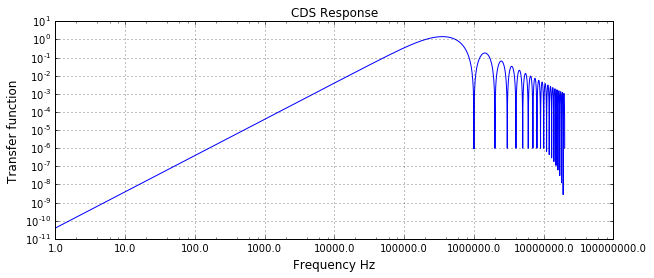

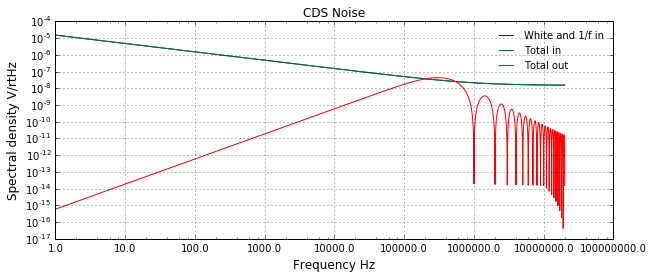

In [12]:
#open the sensor data file
%matplotlib inline
strh5 = ryfiles.open_HDF(hdffilename)
p = ryplot.Plotter(1,1,1,figsize=(10,4))
p.logLog(1, strh5['rystare/sourcefollower/noise/spectralfreq'].value.T, 
         strh5['rystare/sourcefollower/noise/cdsgain'].value.T,'CDS Response',
        'Frequency Hz','Transfer function')
q = ryplot.Plotter(2,1,1,figsize=(10,4))
q.logLog(1, strh5['rystare/sourcefollower/noise/spectralfreq'].value.T, 
         np.sqrt(strh5['rystare/sourcefollower/noise/spectrumwhiteflicker'].value.T),label=['White and 1/f in'])
if strh5['rystare/sensortype'].value in ['CMOS']:
    q.logLog(1, strh5['rystare/sourcefollower/noise/spectralfreq'].value.T, 
         np.sqrt(strh5['rystare/sourcefollower/noise/spectrumRTN'].value.T), label=['Burst / RTN in'])
q.logLog(1, strh5['rystare/sourcefollower/noise/spectralfreq'].value.T, 
         np.sqrt(strh5['rystare/sourcefollower/noise/spectrumtotal'].value.T),label=['Total in'])
q.logLog(1, strh5['rystare/sourcefollower/noise/spectralfreq'].value.T, 
         np.sqrt(strh5['rystare/sourcefollower/noise/spectrumtotal'].value.T) * strh5['rystare/sourcefollower/noise/cdsgain'].value.T,'CDS Noise',
        'Frequency Hz','Spectral density V/rtHz',label=['Total out'])
strh5.flush()
strh5.close()

In [13]:
def plotResults(imghd5, hdffilename, arrayname, units='xx', bins=50, plotscale=1.0, logscale=False):
    if imghd5 is not None and hdffilename is not None:
        mpl.rc("savefig", dpi=plotdpi)
        #open the sensor data file
        strh5 = ryfiles.open_HDF(hdffilename)
        #get the prescribed array
        arr = strh5['{}'.format(arrayname)].value 
        maxarr = np.max(arr)
        arr = strh5['{}'.format(arrayname)].value * plotscale
        arr = np.where(arr > maxarr, maxarr,arr) / plotscale
        if logscale:
            arr = np.log10(arr + 0.5)
            ptitle = "log('{}'+0.5)".format(arrayname.replace('rystare/',''))
        else:
            ptitle = "'{}'".format(arrayname.replace('rystare/',''))
            
        if np.max(arr) > 1000. or np.max(arr) < 1e-2:
            ptitle = '{} [{}] ({:.2e} : {:.2e})'.format(ptitle, units,np.min(arr),np.max(arr) )
        else:
            ptitle = '{} [{}] ({:.4f} : {:.4f})'.format(ptitle, units,np.min(arr),np.max(arr) )
        
        his, binh = np.histogram(arr,bins=bins)
        
        if np.min(arr) != np.max(arr):
            arrshift = arr - np.min(arr)
            arrshift = 255 * arrshift/np.max(arrshift)
            
            p = ryplot.Plotter(1,1,1,figsize=(8, 2))
            p.showImage(1, arr, ptitle=ptitle, cmap=mcm.jet, cbarshow=True);

            q = ryplot.Plotter(2,1,1,figsize=(8, 2))
            q.showImage(1, arrshift, ptitle=ptitle, cmap=mcm.gray, cbarshow=False);

        if not logscale:
            r = ryplot.Plotter(3,1,1,figsize=(4,4))
            r.plot(1, (binh[1:]+binh[:-1])/2, his, 
                   '{}, {} bins'.format(arrayname.replace('rystare/',''), bins), 
                   'Magnitude','Counts / bin',maxNX=5)

        strh5.flush()
        strh5.close()

The graph in the rest of the document shows signals at the stations marked in the signal flow diagram shown below.

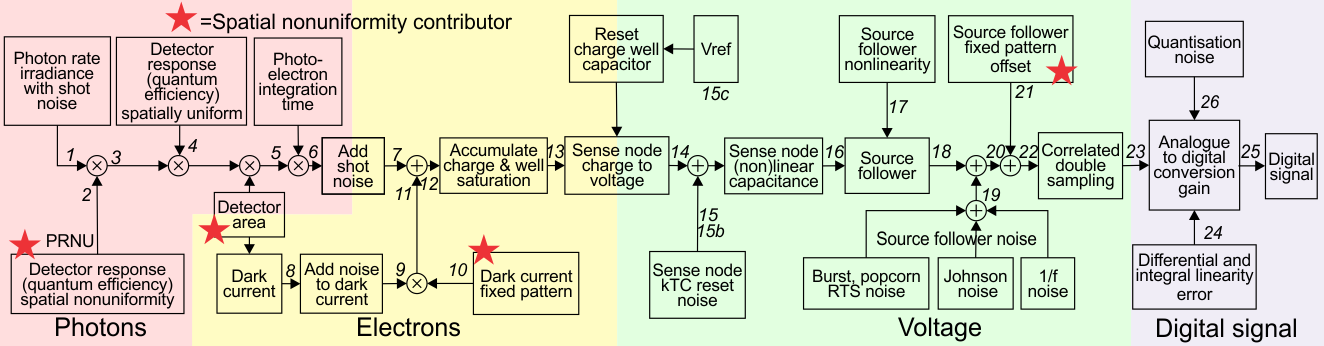

In [14]:
display(Image(filename='images/camerascheme-horiz.png', width=1000))

The following description follows  the signal through the processing chain, step by step, showing the relevant signal or noise at that step.

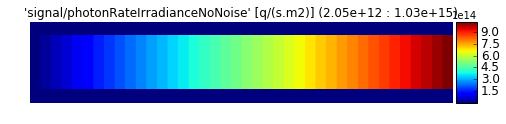

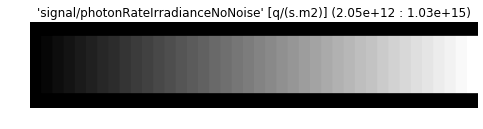

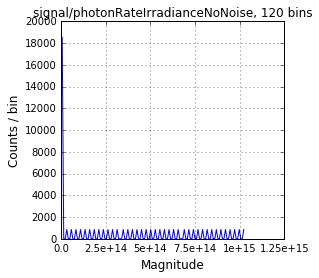

In [15]:
##
plotResults(imghd5, hdffilename, 'rystare/signal/photonRateIrradianceNoNoise', units='q/(s.m2)', bins=120) 

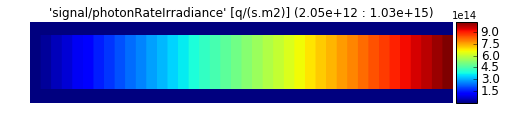

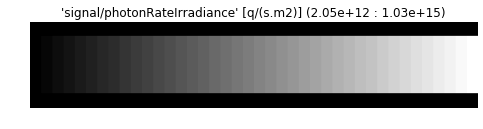

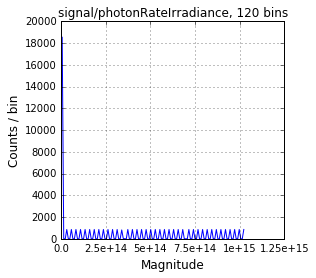

In [16]:
##
plotResults(imghd5, hdffilename, 'rystare/signal/photonRateIrradiance', units='q/(s.m2)', bins=120) 

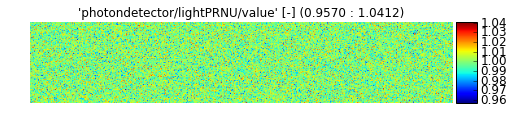

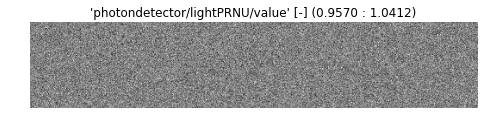

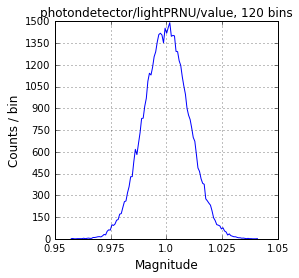

In [17]:
##
plotResults(imghd5, hdffilename, 'rystare/photondetector/lightPRNU/value', units='-', bins=120) 

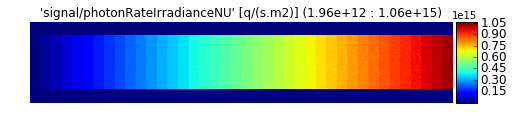

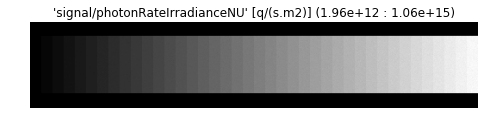

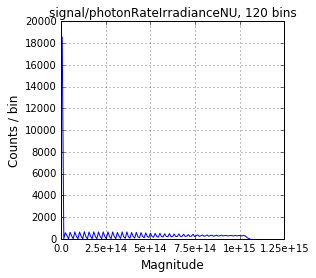

In [18]:
##
plotResults(imghd5, hdffilename, 'rystare/signal/photonRateIrradianceNU', units='q/(s.m2)', bins=120) 

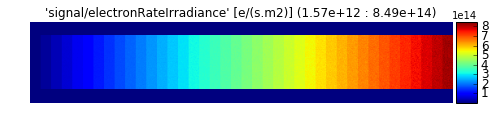

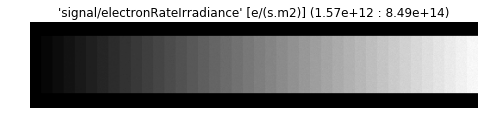

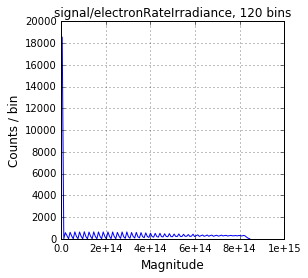

In [19]:
##
plotResults(imghd5, hdffilename, 'rystare/signal/electronRateIrradiance', units='e/(s.m2)', bins=120) 

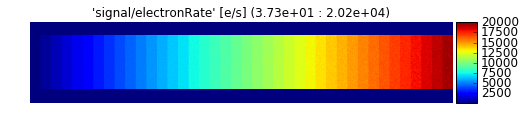

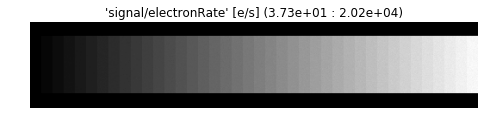

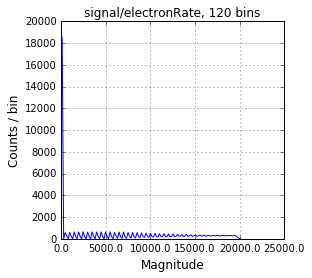

In [20]:
plotResults(imghd5, hdffilename, 'rystare/signal/electronRate', units='e/s', bins=120) 

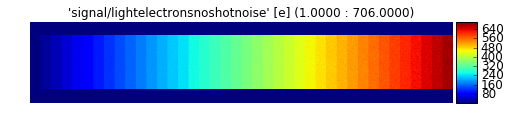

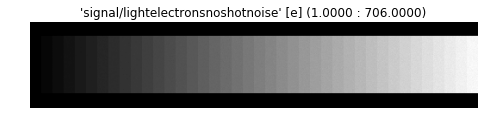

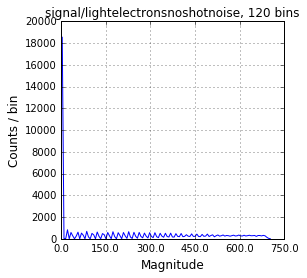

In [21]:
plotResults(imghd5, hdffilename, 'rystare/signal/lightelectronsnoshotnoise', units='e', bins=120) 

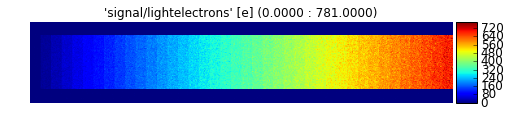

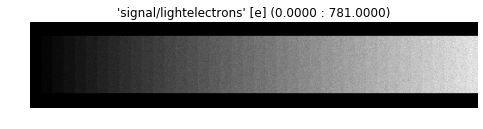

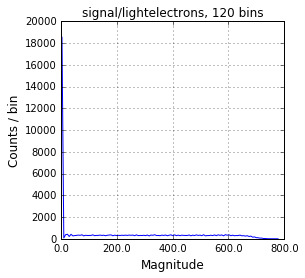

In [22]:
plotResults(imghd5, hdffilename, 'rystare/signal/lightelectrons', units='e', bins=120) 

In [23]:
##
strh5 = ryfiles.open_HDF(hdffilename)
print('Average dark current {:.3e} electrons'.format(strh5['rystare/darkcurrentelectronsnonoise'].value))
strh5.flush()
strh5.close()


Average dark current 5.466e+01 electrons


Before dark FPN:
Minimum dark current 2.700e+01 electrons
Average dark current 5.465e+01 electrons
Maximum dark current 8.700e+01 electrons
After dark FPN:
Minimum dark current 3.597e+01 electrons
Average dark current 1.445e+02 electrons
Maximum dark current 5.031e+03 electrons


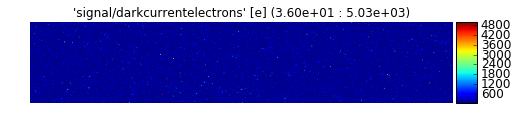

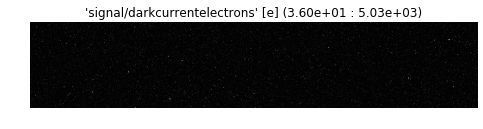

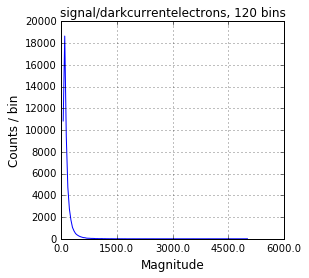

In [24]:
plotResults(imghd5, hdffilename, 'rystare/signal/darkcurrentelectrons', units='e',  bins=120) 

strh5 = ryfiles.open_HDF(hdffilename)
print('Before dark FPN:')
print('Minimum dark current {:.3e} electrons'.format(np.min(strh5['rystare/signal/darkcurrentelectronsnoDFPN'].value)))
print('Average dark current {:.3e} electrons'.format(np.mean(strh5['rystare/signal/darkcurrentelectronsnoDFPN'].value)))
print('Maximum dark current {:.3e} electrons'.format(np.max(strh5['rystare/signal/darkcurrentelectronsnoDFPN'].value)))
print('After dark FPN:')
print('Minimum dark current {:.3e} electrons'.format(np.min(strh5['rystare/signal/darkcurrentelectrons'].value)))
print('Average dark current {:.3e} electrons'.format(np.mean(strh5['rystare/signal/darkcurrentelectrons'].value)))
print('Maximum dark current {:.3e} electrons'.format(np.max(strh5['rystare/signal/darkcurrentelectrons'].value)))
strh5.flush()
strh5.close()

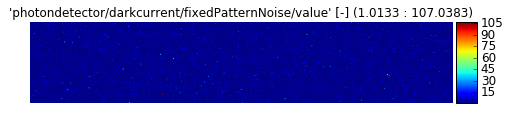

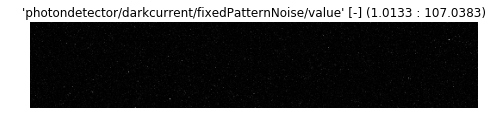

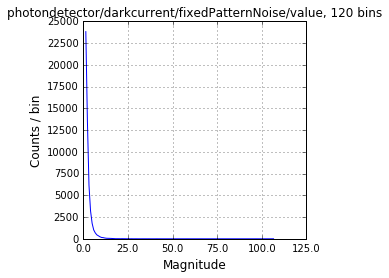

In [25]:
plotResults(imghd5, hdffilename, 'rystare/photondetector/darkcurrent/fixedPatternNoise/value', units='-', bins=120) 

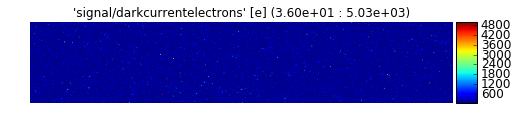

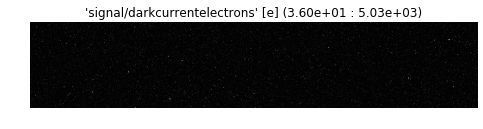

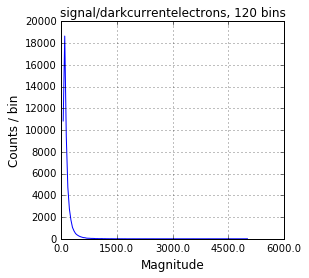

In [26]:
plotResults(imghd5, hdffilename, 'rystare/signal/darkcurrentelectrons', units='e',  bins=120) 

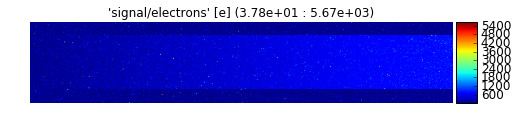

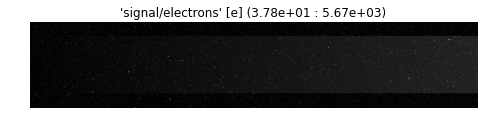

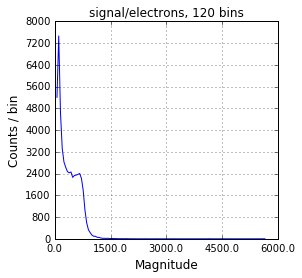

In [27]:
plotResults(imghd5, hdffilename, 'rystare/signal/electrons', units='e',   bins=120) 

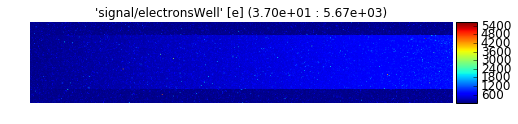

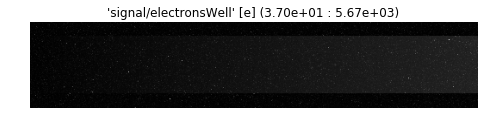

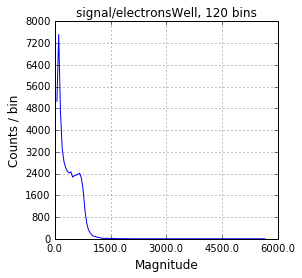

In [28]:
plotResults(imghd5, hdffilename, 'rystare/signal/electronsWell', units='e',  bins=120) 


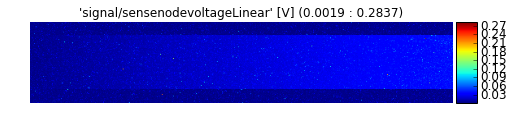

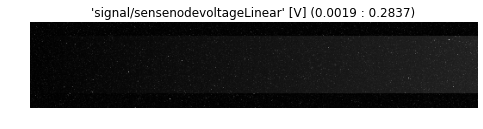

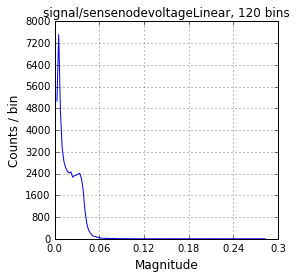

In [29]:
plotResults(imghd5, hdffilename, 'rystare/signal/sensenodevoltageLinear', units='V',  bins=120) 

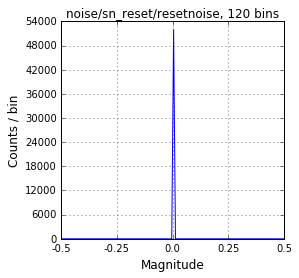

In [30]:
plotResults(imghd5, hdffilename, 'rystare/noise/sn_reset/resetnoise', units='V',  bins=120) 

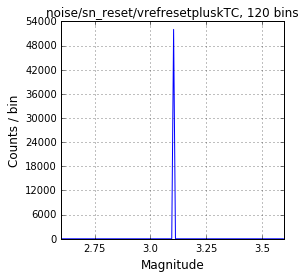

In [31]:
plotResults(imghd5, hdffilename, 'rystare/noise/sn_reset/vrefresetpluskTC', units='V',  bins=120) 

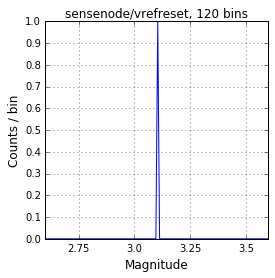

In [32]:
plotResults(imghd5, hdffilename, 'rystare/sensenode/vrefreset', units='V',  bins=120) 

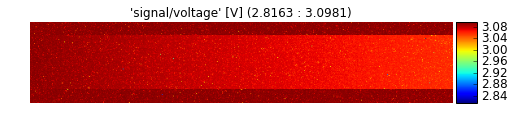

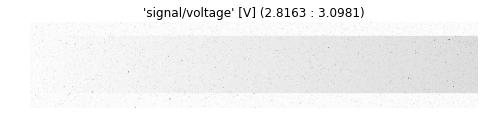

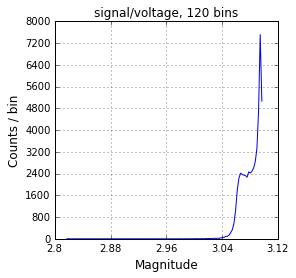

In [33]:
plotResults(imghd5, hdffilename, 'rystare/signal/voltage', units='V',  bins=120) 

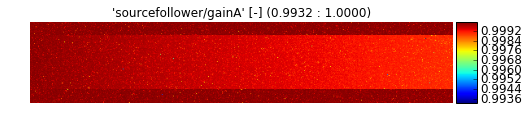

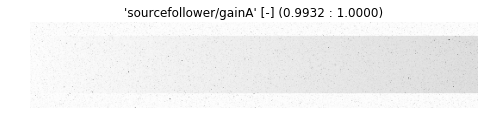

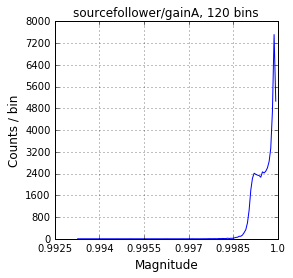

In [34]:
plotResults(imghd5, hdffilename, 'rystare/sourcefollower/gainA', units='-',  bins=120) 

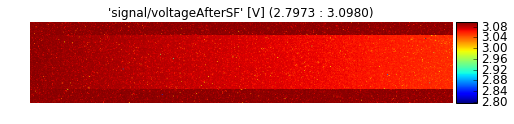

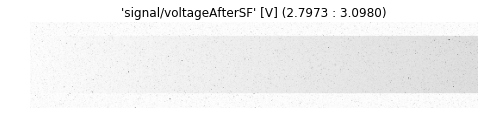

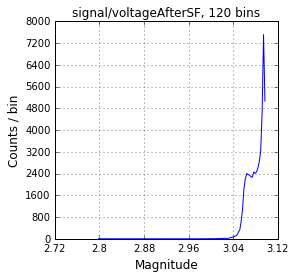

In [35]:
plotResults(imghd5, hdffilename, 'rystare/signal/voltageAfterSF', units='V',   bins=120) 

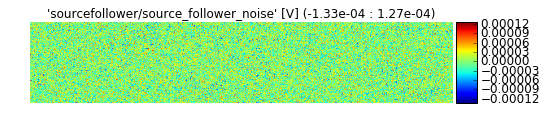

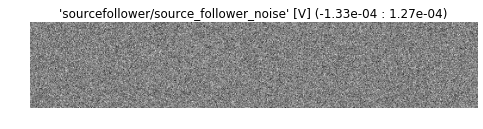

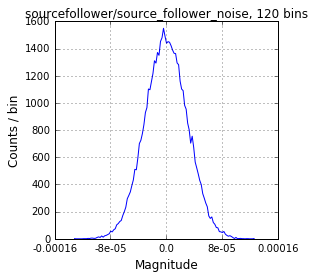

In [36]:
plotResults(imghd5, hdffilename, 'rystare/sourcefollower/source_follower_noise', units='V',  bins=120) 

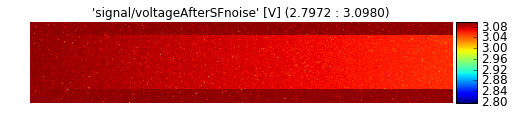

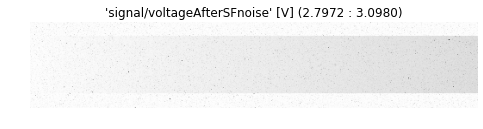

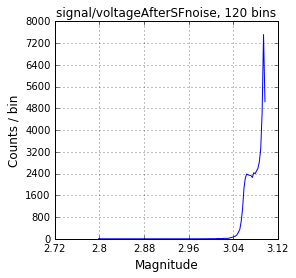

In [37]:
plotResults(imghd5, hdffilename, 'rystare/signal/voltageAfterSFnoise', units='V',  bins=120) 

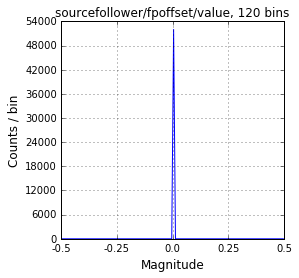

In [38]:
plotResults(imghd5, hdffilename, 'rystare/sourcefollower/fpoffset/value', units='V',  bins=120) 

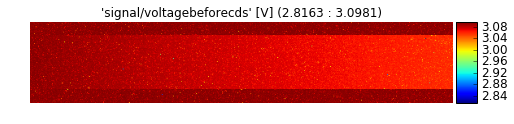

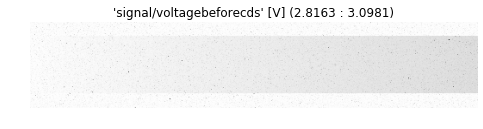

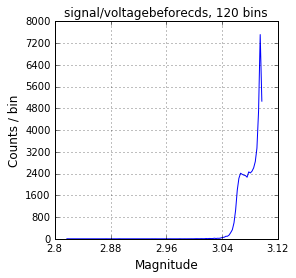

In [39]:
plotResults(imghd5, hdffilename, 'rystare/signal/voltagebeforecds', units='V',  bins=120) 

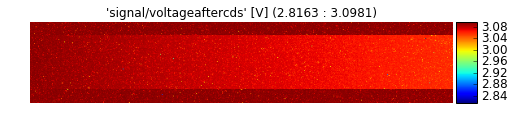

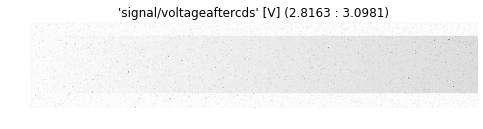

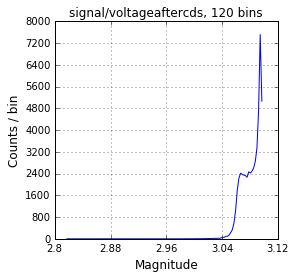

In [40]:
plotResults(imghd5, hdffilename, 'rystare/signal/voltageaftercds', units='V',  bins=120) 

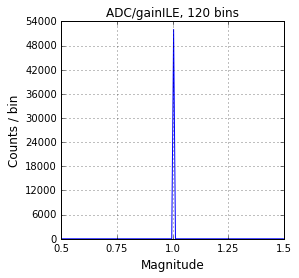

In [41]:
plotResults(imghd5, hdffilename, 'rystare/ADC/gainILE', units='-',  bins=120) 

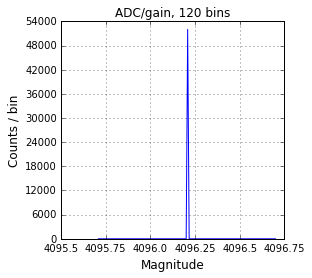

In [42]:
plotResults(imghd5, hdffilename, 'rystare/ADC/gain', units='DN/V',   bins=120) 

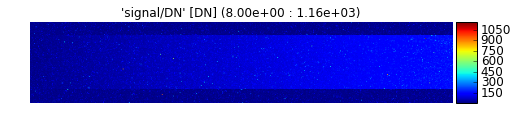

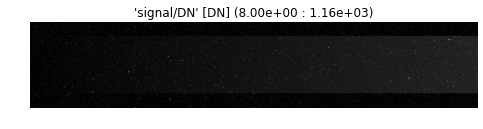

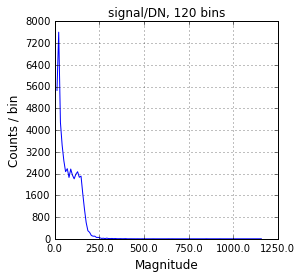

In [43]:
plotResults(imghd5, hdffilename, 'rystare/signal/DN', units='DN', bins=120) 

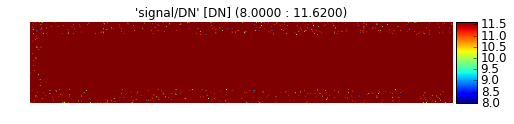

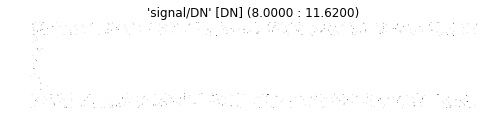

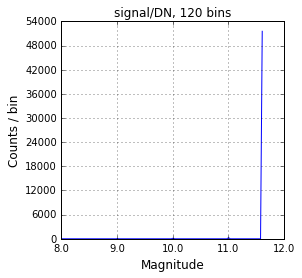

In [44]:
plotResults(imghd5, hdffilename, 'rystare/signal/DN', units='DN', bins=120, plotscale=100) 

Signal converted to digital counts  (location 27 in the diagram). This graph shows the log-base10 values in the image. The image is offset by half a digital count to prevent log(0) errors.

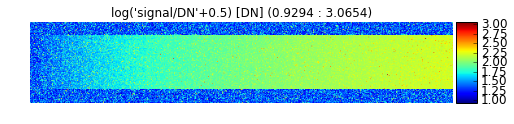

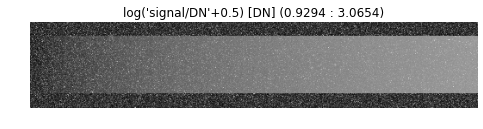

In [45]:
plotResults(imghd5, hdffilename, 'rystare/signal/DN', units='DN', bins=120, plotscale=1, logscale=True) 

Next we will attempt to calculate the photon transfer function and signal to noise ratio for the various parts of the image.

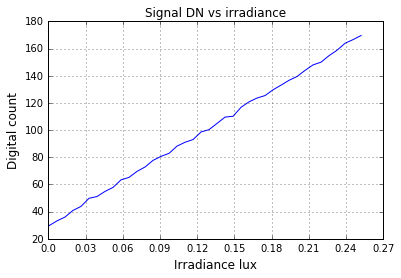

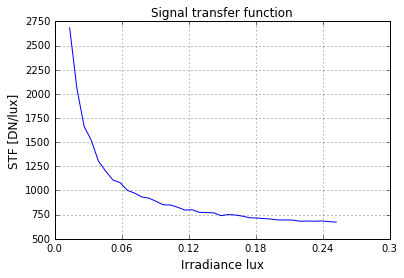

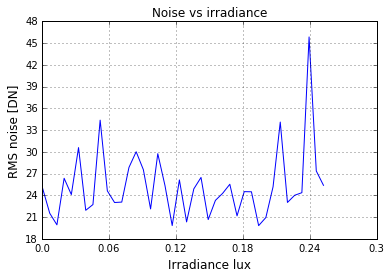

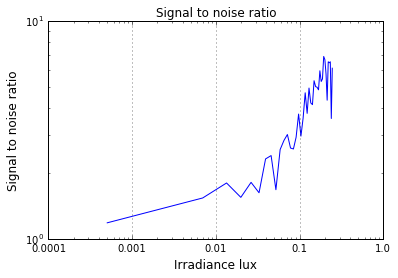

In [46]:
tplZones = collections.namedtuple('tplZones', ['ein', 'count','mean','var','std','snr','stf'], verbose=False)
lstZones = []
if imghd5 is not None:
    strh5 = ryfiles.open_HDF(hdffilename)
    #get the list of unique zones in the image
    arrnn = strh5['rystare/equivalentSignal'].value
#     arrnn = strh5['rystare/PhotonRateIrradianceNoNoise'].value
    arr = strh5['rystare/signal/DN'].value
    uniqueZs, uCnts = np.unique(arrnn, return_counts=True)
#     print(uniqueZs, uCnts)
    for uniqueZ,ucnt in zip(uniqueZs,uCnts):
        zone = arr[arrnn==uniqueZ]
        mean = np.mean(zone)
        lstZones.append(tplZones(ein=uniqueZ, count=ucnt, mean=mean, 
                        var=np.var(zone-mean), std=np.std(zone-mean), 
                        snr=np.mean(zone)/np.std(zone-mean),
                        stf=np.mean(zone)/uniqueZ))
    equivalentSignalLabel = '{} {}'.format(strh5['rystare/equivalentSignalType'].value,
                                       strh5['rystare/equivalentSignalUnit'].value)

    strh5.flush()
    strh5.close()


# print(lstZones) 
#build numpy arrays of the results
ein = np.asarray([x.ein for x in lstZones])
mean = np.asarray([x.mean for x in lstZones])
var = np.asarray([x.var for x in lstZones])
std = np.asarray([x.std for x in lstZones])
snr = np.asarray([x.snr for x in lstZones])
stf = np.asarray([x.stf for x in lstZones])

figsize = (6,4)
p = ryplot.Plotter(1,1,1,figsize=figsize);
p.plot(1,ein,mean,'Signal DN vs irradiance',equivalentSignalLabel,'Digital count');
q = ryplot.Plotter(2,1,1,figsize=figsize);
q.plot(1,ein[2:],stf[2:],'Signal transfer function',equivalentSignalLabel,'STF [DN/lux]',maxNX=5);
r = ryplot.Plotter(3,1,1,figsize=figsize);
r.plot(1,ein,std,'Noise vs irradiance',equivalentSignalLabel,'RMS noise [DN]',maxNX=5);
s = ryplot.Plotter(4,1,1,figsize=figsize);
s.logLog(1,ein[:-1],snr[:-1],'Signal to noise ratio',equivalentSignalLabel,'Signal to noise ratio');
# s.logLog(1,mean[:-1],snr[:-1],'SNR [-] vs mean [DN]');


## Python and [module versions, and dates](http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-0-Scientific-Computing-with-Python.ipynb)

In [90]:
# you only need to do this once
#!pip install --upgrade version_information

%load_ext version_information
%version_information numpy, scipy, matplotlib, pyradi

Software versions
Python 2.7.12 64bit [MSC v.1500 64 bit (AMD64)]
IPython 5.1.0
OS Windows 7 6.1.7601 SP1
numpy 1.11.1
scipy 0.18.1
matplotlib 1.5.3
pyradi 0.2.3
Fri Oct 21 09:30:08 2016 South Africa Standard Time